<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/Dividend_Yield_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime


path = os.getcwd()
print(path)

/content


In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-04 23:57:06--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-04 23:57:06--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-04 23:57:06--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [5]:
import talib 
from talib import abstract

## 抓取資料

In [6]:
# symbol_list = ['0050.TW','0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
#                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW', '00728.TW', 
#                '00730.TW', '00731.TW', '00733.TW', '00735.TW']
# for i in range(len(symbol_list)):
symbol = '006208.TW'

data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
# fifty.to_csv(path+'/0050.csv')
# df_0050 = pd.read_csv(path+'/0050.csv')
# df_0050 = df_0050.set_index(pd.to_datetime(df_0050['Date']))
# df_0050 = df_0050.drop('Date', axis = 1)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)
df.head(5)

,open,high,low,close,volume,0050,0051,0052,0053,0055,...,00701,00712,00713,00714,00717,00728,00730,00731,00733,00735
2009-10-13,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-14,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-15,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-19,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Strategy

主要策略 => 息收前後進場
1. 除息日前 x 天進場，前 y 天出場
2. 除昔日後 z 天進場，(等回補出場)



In [8]:

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

In [9]:
df

,open,high,low,close,volume,0050,0051,0052,0053,0055,...,00714,00717,00728,00730,00731,00733,00735,EMA,MACD,SAR
2009-10-13,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-10-14,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-10-15,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-10-16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-10-19,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,68.800003,69.199997,67.599998,67.800003,5166733.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.872637
2022-06-24,68.349998,68.699997,67.900002,68.000000,1675871.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.239920
2022-06-27,69.000000,70.000000,69.000000,69.500000,3156555.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.683130
2022-06-28,69.449997,69.449997,68.699997,69.000000,1402489.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.193154


            profit
2009-10-13     0.0
2009-10-14     0.0
2009-10-15     0.0
2009-10-16     0.0
2009-10-19     0.0
...            ...
2022-06-22     NaN
2022-06-23     NaN
2022-06-24     NaN
2022-06-27     NaN
2022-06-28     NaN

[3128 rows x 1 columns]


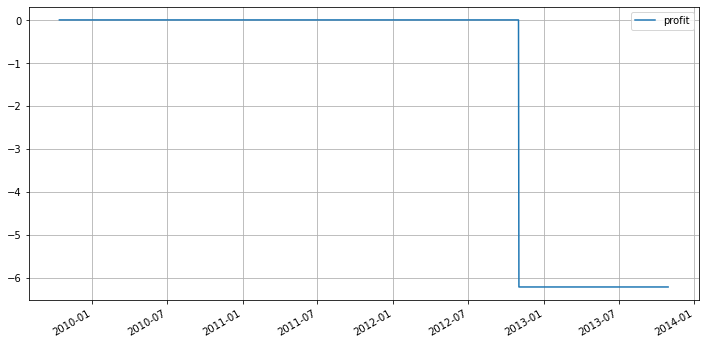

In [10]:
# 主要策略

profit_list = []
price = []
buy = []
# buy2 = []
sell = []
# sell2 = []
open_price = []
position = "A"
timeList = []

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['006208'][i] > 0 and df['close'][i] > 0: # 除息日
        tempSize = money / df['close'][i-30] # 前 15 天進場
        buy.append(i-30)
  
        profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
        sell.append(i-5)
        profit_list.append(profit)
        timeList.append(df.index[i]) 

        # temp2 = money / df['Open'][i+1] # 除息隔天進場
        # buy2.append(i+1)
        # price.append(df['close'][i-1]) # 除息日前一天收盤價
        # open_price.append(df['Open'][i+1]) # 進場開盤價
        # position = "B"

        
    # elif position == "B" and df['close'][i] >= price[-1]:   # 若除息日後仍有部位且收盤價大於當時買入價 => 隔天開盤回補
    #     profit = temp2 * (df['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 
    #     position = "A"

    # elif position == 'B' and (df['close'][i] - price[-1]) / df['close'][i] < -0.1 : # 停損：<-10%
    #     profit = temp2 * (df['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 
    #     position = "A"

    else:
      profit_list.append(0)
      timeList.append(df.index[i])


# equity = pd.DataFrame({'profit':profit_list}, index=timeList)

equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

In [11]:
# 實際交易位置
print(buy)
print(sell)
# print(buy2)
# print(sell2)

[734, 978, 1224, 1469, 1654, 1895, 1983, 2141, 2229, 2380, 2464, 2624, 2706, 2866, 2950]
[759, 1003, 1249, 1494, 1679, 1920, 2008, 2166, 2254, 2405, 2489, 2649, 2731, 2891, 2975]


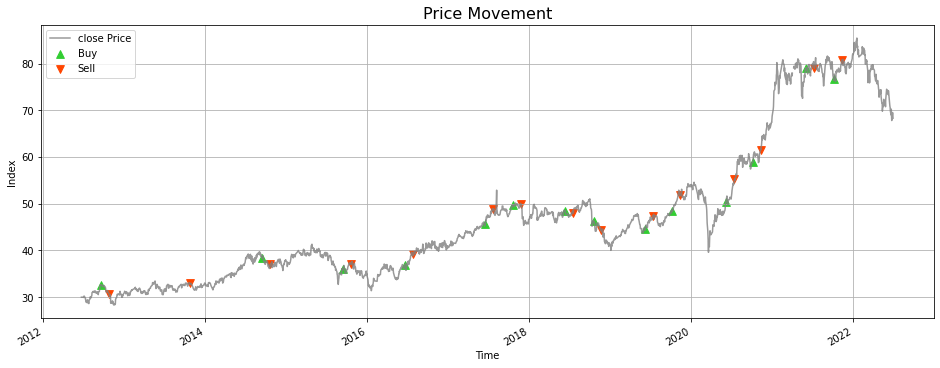

In [12]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

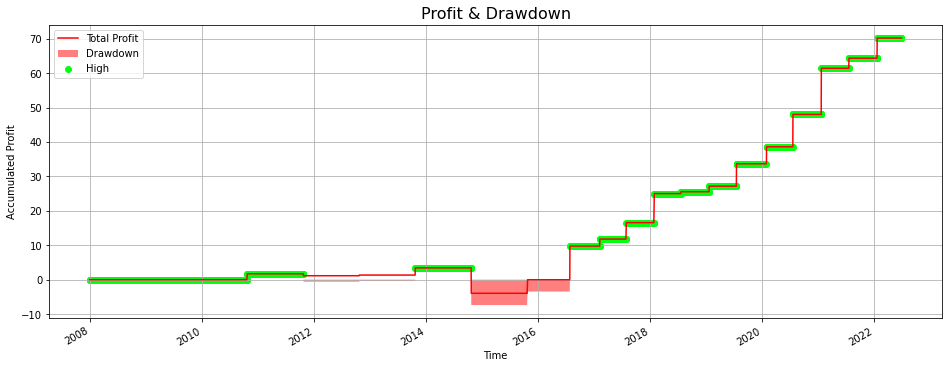

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

# 成網格狀是因為一次加總多天報酬

# 整合

In [27]:
symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = []
buy = []
sell = []
open_price = []
position = "A"
timeList = []

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
        tempSize = money / df['close'][i-30] # 前 15 天進場
        buy.append(i-30)
  
        profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
        sell.append(i-5)
        profit_list.append(profit)
        timeList.append(df.index[i]) 


    else:
      profit_list.append(0)
      timeList.append(df.index[i])

equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
  
########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['date']))
  Yield = Yield.drop('date', axis = 1)
  df = pd.concat([df,Yield], join='outer', axis=1)

  # initial setting

  fund = 100 #初始有100元本金
  money = 100 #每次投入
  feeRate = 0.003 #手續費

  # 主要策略

  profit_list = []
  price = []
  buy = []
  sell = []
  open_price = []
  position = "A"
  timeList = []

  for i in range(len(df)):

      if i == len(df)-1:
        break
      
      if df.iloc[:,j+6][i] > 0 and df['close'][i] > 0: # 除息日 => 每標的:df.iloc[:,j+6][i]
          tempSize = money / df['close'][i-30] # 前 15 天進場
          buy.append(i-30)
    
          profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
          sell.append(i-5)
          profit_list.append(profit)
          timeList.append(df.index[i]) 


      else:
        profit_list.append(0)
        timeList.append(df.index[i])

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):np.cumsum(profit_list)}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

equity

,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2008-01-02,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-08,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,70.191029,-4.99301,8.983781,16.142657,2.18415,-12.636289,61.677872,-7.646297,NaN,17.26378,...,15.801877,28.621307,15.900651,0.463929,-6.261634,29.955751,-11.90406,10.470851,-3.152845,21.806488
2022-06-23,70.191029,-4.99301,8.983781,16.142657,2.18415,-12.636289,61.677872,-7.646297,NaN,17.26378,...,15.801877,28.621307,15.900651,0.463929,-6.261634,29.955751,-11.90406,10.470851,-3.152845,21.806488
2022-06-24,70.191029,-4.99301,8.983781,16.142657,2.18415,-12.636289,61.677872,-7.646297,NaN,17.26378,...,15.801877,28.621307,15.900651,0.463929,-6.261634,29.955751,-11.90406,10.470851,-3.152845,21.806488
2022-06-27,70.191029,-4.99301,8.983781,16.142657,2.18415,-12.636289,61.677872,-7.646297,NaN,17.26378,...,15.801877,28.621307,15.900651,0.463929,-6.261634,29.955751,-11.90406,10.470851,-3.152845,21.806488


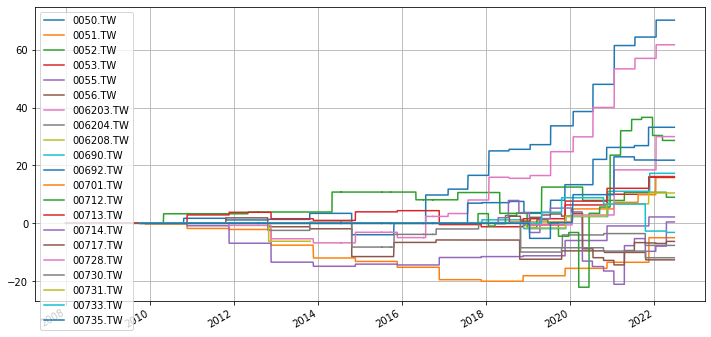

In [28]:
equity.plot(grid=True, figsize=(12, 6));

In [29]:
equity.iloc[-1].mean()

14.302135379208972

### 新策略 => 順勢策略
1. EMA : df['Close'] > EMA(200)
2. MACD : MACD > 0
3. SAR : SAR < df['Close'] 

* 停損 : stopLoss = df['Close'][i] - SAR[i]
* 停利 : = stopLoss

In [33]:
symbol = '0051.TW'

data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)
df

,open,high,low,close,volume,EMA,MACD,SAR
Date,,,,,,,,
2008-01-02,33.139999,33.139999,33.139999,33.139999,0,NaN,NaN,NaN
2008-01-03,32.549999,32.549999,32.549999,32.549999,0,NaN,NaN,33.139999
2008-01-04,32.730000,32.730000,32.730000,32.730000,0,NaN,NaN,33.128199
2008-01-07,31.250000,31.250000,31.250000,31.250000,0,NaN,NaN,33.116635
2008-01-08,31.389999,31.389999,31.389999,31.389999,0,NaN,NaN,33.041970
...,...,...,...,...,...,...,...,...
2022-06-23,53.299999,53.849998,52.750000,53.150002,32095,57.053703,-0.905117,56.074311
2022-06-24,53.950001,54.000000,53.299999,53.799999,14119,57.021328,-0.915282,55.675394
2022-06-27,54.500000,54.849998,54.349998,54.750000,25200,56.998727,-0.837031,55.324347


               profit  profitfee
2009-04-10   0.000000   0.000000
2009-05-18  14.678903  14.034866
2009-06-18   4.825905   3.611428
2010-09-13  25.225907  23.350229
2011-08-08  14.778147  12.333812
2012-04-05  10.277958   7.247124
2012-11-22  -0.325814  -3.924836
2013-03-11   6.043116   1.824987
2013-03-18   3.489450  -1.321018
2013-05-21  11.096126   5.662838
2013-05-23   9.840018   3.810498
2013-10-11  23.606061  16.935243
2013-11-04  21.211050  13.947417
2014-07-04  25.995417  18.117430
2014-09-23  23.898644  15.426948
2015-06-09  18.326404   9.271425
2016-04-06  13.374758   3.734633
2016-08-05  19.866192   9.606593
2016-08-17  18.485076   7.629621
2016-09-14  18.033103   6.579004
2016-11-02  14.440513   2.397191
2018-04-16  44.166010  31.433512
2018-04-25  41.317530  27.993577
2018-10-05  35.122042  21.216676
2019-04-03  40.099273  25.578975
2019-05-10  37.716846  22.603695
2019-09-06  44.031315  28.299221
2020-01-20  45.900472  29.562770
2020-03-09  39.252831  22.335073
2020-12-02

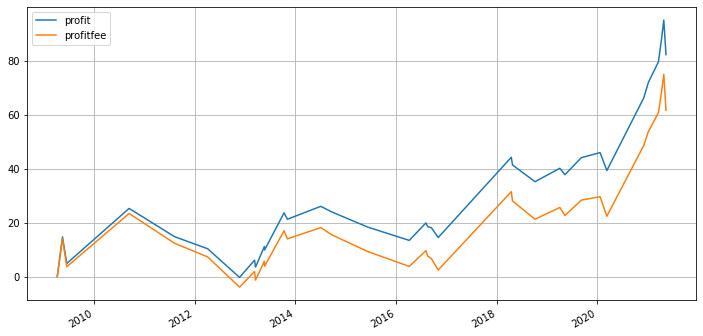

In [34]:
# 新策略

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

[311, 338, 368, 671, 1015, 1117, 1243, 1285, 1312, 1333, 1369, 1431, 1485, 1610, 1733, 2025, 2106, 2126, 2140, 2158, 2225, 2539, 2557, 2751, 2776, 2827, 2883, 2986, 3034, 3184, 3206, 3251, 3263, 3275, 3297]
[337, 358, 670, 893, 1054, 1217, 1284, 1289, 1332, 1334, 1430, 1446, 1609, 1665, 1837, 2040, 2125, 2133, 2154, 2186, 2538, 2545, 2659, 2775, 2799, 2882, 2972, 2999, 3183, 3205, 3250, 3262, 3274, 3285]


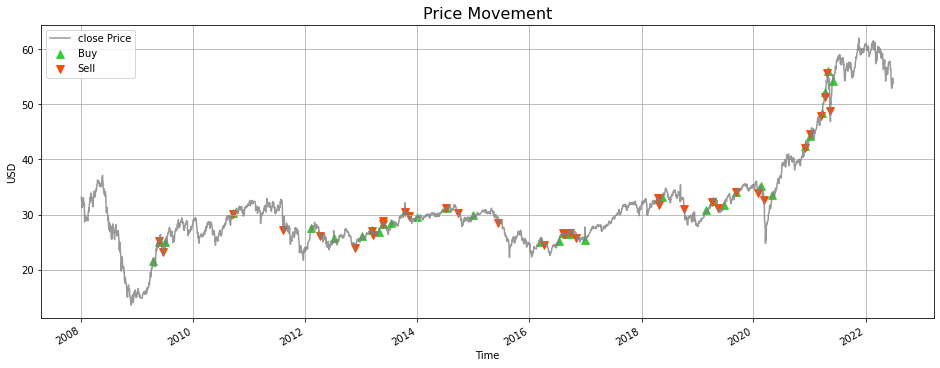

In [23]:
# 實際交易位置
print(buy)
print(sell)
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

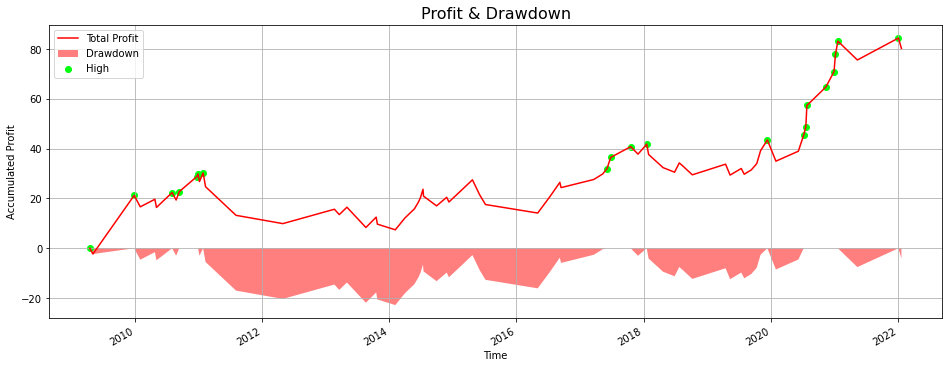

In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


## Optimization

* 進場時間

df_in = df[:'2020-01']

df_out = df['2020-02':]

## 主策略

In [ ]:
opt_list = []

symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)
df_in = df[:'2020-01']

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

for In in range(27, 31):
  for Out in range(3, 8):
    
    print('----------')
    print(f'In: {In}')
    print(f'Out: {Out}')
  
    

    # 主要策略

    profit_list = []
    price = []
    buy = []
    sell = []
    open_price = []
    position = "A"
    timeList = []

    for i in range(len(df_in)):

        if i == len(df_in)-1:
          break
        
        if df_in['0050'][i] > 0 and df_in['close'][i] > 0: # 除息日
            tempSize = money / df_in['close'][i-In] # 前 15 天進場
            buy.append(i-In)
      
            profit = tempSize * (df_in['close'][i-Out] - df_in['close'][i-In]) # 前 5 天出場並計算報酬
            sell.append(i-Out)
            profit_list.append(profit)
            timeList.append(df_in.index[i]) 


        else:
          profit_list.append(0)
          timeList.append(df_in.index[i])

    equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
      
    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-6-30')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      Yield = pd.read_csv(path + '/yield.csv')
      Yield = Yield.set_index(pd.to_datetime(Yield['date']))
      Yield = Yield.drop('date', axis = 1)
      df = pd.concat([df,Yield], join='outer', axis=1)
      df_in = df[:'2020-01']

      # initial setting

      fund = 100 #初始有100元本金
      money = 100 #每次投入
      feeRate = 0.003 #手續費

      # 主要策略

      profit_list = []
      price = []
      buy = []
      sell = []
      open_price = []
      position = "A"
      timeList = []

      for i in range(len(df_in)):

          if i == len(df_in)-1:
            break
          
          if df_in.iloc[:,j+6][i] > 0 and df_in['close'][i] > 0: # 除息日
              tempSize = money / df_in['close'][i-In] # 前 In 天進場
              buy.append(i-In)
        
              profit = tempSize * (df_in['close'][i-Out] - df_in['close'][i-In]) # 前 Out 天出場並計算報酬
              sell.append(i-Out)
              profit_list.append(profit)
              timeList.append(df_in.index[i]) 


          else:
            profit_list.append(0)
            timeList.append(df_in.index[i])

      pp = pd.DataFrame({'{}'.format(symbol_list[j]):np.cumsum(profit_list)}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

    ret = equity.iloc[-1].mean()
    opt_list.append([In, Out, ret])

----------
In: 27
Out: 3
----------
In: 27
Out: 4
----------
In: 27
Out: 5
----------
In: 27
Out: 6
----------
In: 27
Out: 7
----------
In: 28
Out: 3
----------
In: 28
Out: 4
----------
In: 28
Out: 5
----------
In: 28
Out: 6
----------
In: 28
Out: 7
----------
In: 29
Out: 3
----------
In: 29
Out: 4
----------
In: 29
Out: 5
----------
In: 29
Out: 6
----------
In: 29
Out: 7
----------
In: 30
Out: 3
----------
In: 30
Out: 4
----------
In: 30
Out: 5
----------
In: 30
Out: 6
----------
In: 30
Out: 7


In [ ]:
optResult = pd.DataFrame(opt_list, columns=['In','Out','return'])
optResult.sort_values('return', ascending = False)

,In,Out,return
0,27,3,5.107776
6,28,4,4.499667
1,27,4,4.324314
11,29,4,4.296884
5,28,3,4.022442
7,28,5,3.897235
16,30,4,3.841649
10,29,3,3.675508
2,27,5,3.502788
12,29,5,3.437744


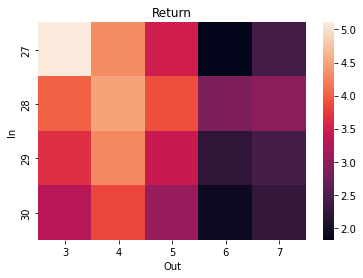

In [ ]:
pic = optResult.pivot('In', 'Out', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

## 濾網(MACD)
* result : fast = 9, slow = 24

* or fast = 7, slow = 32

* or fast = 9, slow = 22

In [31]:
for i in range(20, 41, 2):
  print(i)

20
22
24
26
28
30
32
34
36
38
40


In [41]:
# 新策略
opt_list = []

symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2020-1-1')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

for fast in range(5, 20, 2):
  for slow in range(20, 41, 2):

    print('----------')
    print(f'fast: {fast}')
    print(f'slow: {slow}')

    
    df['EMA'] = abstract.EMA(df, timeperiod = 200)
    df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])

            
            if first == 0:
                timeList.append(df.index[i+1])
                first = 1
            continue

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        

    equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)
    ret = equity['profitfee'].iloc[-1]
    opt_list.append([fast, slow, ret])

----------
fast: 5
slow: 20
----------
fast: 5
slow: 22
----------
fast: 5
slow: 24
----------
fast: 5
slow: 26
----------
fast: 5
slow: 28
----------
fast: 5
slow: 30
----------
fast: 5
slow: 32
----------
fast: 5
slow: 34
----------
fast: 5
slow: 36
----------
fast: 5
slow: 38
----------
fast: 5
slow: 40
----------
fast: 7
slow: 20
----------
fast: 7
slow: 22
----------
fast: 7
slow: 24
----------
fast: 7
slow: 26
----------
fast: 7
slow: 28
----------
fast: 7
slow: 30
----------
fast: 7
slow: 32
----------
fast: 7
slow: 34
----------
fast: 7
slow: 36
----------
fast: 7
slow: 38
----------
fast: 7
slow: 40
----------
fast: 9
slow: 20
----------
fast: 9
slow: 22
----------
fast: 9
slow: 24
----------
fast: 9
slow: 26
----------
fast: 9
slow: 28
----------
fast: 9
slow: 30
----------
fast: 9
slow: 32
----------
fast: 9
slow: 34
----------
fast: 9
slow: 36
----------
fast: 9
slow: 38
----------
fast: 9
slow: 40
----------
fast: 11
slow: 20
----------
fast: 11
slow: 22
----------
fast: 1

In [42]:
optResult = pd.DataFrame(opt_list, columns=['fast','slow','return'])
optResult.sort_values('return', ascending = False)

,fast,slow,return
17,7,32,52.543702
24,9,24,52.543702
23,9,22,52.543702
33,11,20,51.651955
36,11,26,50.381785
...,...,...,...
63,15,36,26.434699
80,19,26,25.815072
71,17,30,25.381744
72,17,32,25.202588


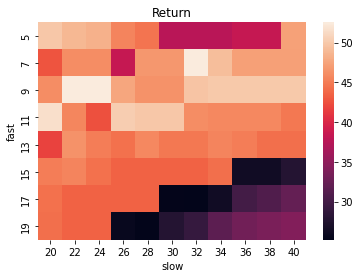

In [43]:
pic = optResult.pivot('fast', 'slow', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

# Combine Final Solution:
* 前 30 天進場
* 前 4 天出場

In [75]:
symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2010-1-1', end='2020-1-1')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = [] # 除息日
buy = []
sell = []
timeList = []
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

# 除息日期間設定
In = 30 
Out = 5

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
      price.append(i)

      for j in range(i-In, i-Out+1):

        if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

            temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            buy.append(j+1)
            stopLoss = df['SAR'][j]
            stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
            continue

           # buy停利
        if df['close'][j] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # buy停損
        if df['close'][j] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # 最後一天平倉
        if j == (i-Out) and BS == 'B': 
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None

equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
equity

,0050.TW
2012-09-17,3.255814
2012-10-18,0.012572
2013-10-18,2.012575
2016-07-13,6.156852
2016-07-22,9.193894
2017-02-02,10.643174
2017-06-27,14.205518
2017-07-25,15.936052
2018-01-19,19.349224
2018-01-23,20.381928


[729, 733, 975, 1665, 1675, 1798, 1904, 1910, 2044, 2055, 2145, 2166, 2396]
[732, 754, 1000, 1674, 1681, 1811, 1909, 1929, 2054, 2056, 2151, 2170, 2413]
[259, 508, 758, 1004, 1252, 1499, 1685, 1815, 1933, 2060, 2174, 2302, 2417]


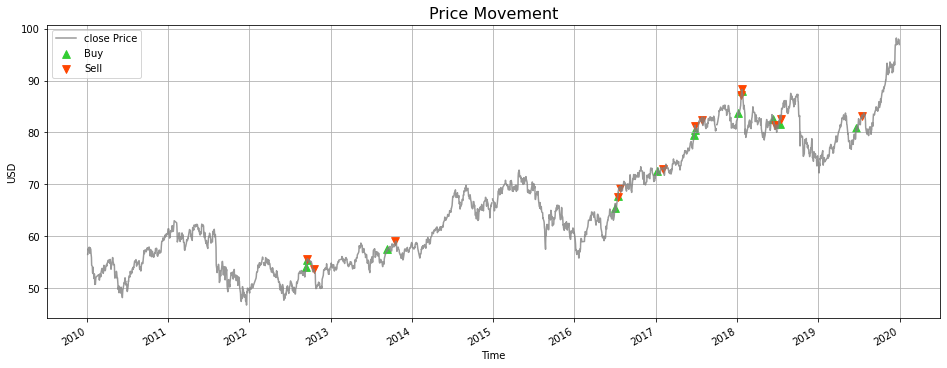

In [76]:
# 實際交易位置
print(buy)
print(sell)
print(price)
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

# Final Code

In [87]:
symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2010-1-1', end='2020-1-1')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = [] # 除息日
buy = []
sell = []
timeList = []
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

# 除息日期間設定
In = 30 
Out = 5

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
      price.append(i)

      for j in range(i-In, i-Out+1):

        if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

            temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            buy.append(j+1)
            stopLoss = df['SAR'][j]
            stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
            continue

           # buy停利
        if df['close'][j] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # buy停損
        if df['close'][j] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # 最後一天平倉
        if j == (i-Out) and BS == 'B': 
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)


########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for k in range(len(symbol_list)):
  symbol = symbol_list[k]

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2010-1-1', end='2020-1-1')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']

  df['EMA'] = abstract.EMA(df, timeperiod = 200)
  df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['date']))
  Yield = Yield.drop('date', axis = 1)
  df = pd.concat([df,Yield], join='outer', axis=1)

  # initial setting

  fund = 100 #初始有100元本金
  money = 100 #每次投入
  feeRate = 0.003 #手續費

  # 主要策略

  profit_list = []
  price = [] # 除息日
  buy = []
  sell = []
  timeList = []
  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  # # 除息日期間設定
  # In = 30 
  # Out = 5

  for i in range(len(df)):

      if i == len(df)-1:
        break
      
      if df.iloc[:,k+9][i] > 0 and df['close'][i] > 0: # 除息日
        price.append(i)

        for j in range(i-In, i-Out+1):

          if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

              temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              buy.append(j+1)
              stopLoss = df['SAR'][j]
              stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
              continue

            # buy停利
          if df['close'][j] > stopEarn and BS == 'B':
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None
              

            # buy停損
          if df['close'][j] < stopLoss and BS == 'B':
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None
              

            # 最後一天平倉
          if j == (i-Out) and BS == 'B': 
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None

  pp = pd.DataFrame({'{}'.format(symbol_list[k]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

equity

,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2010-11-16,NaN,NaN,NaN,NaN,-3.746176,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-17,NaN,-2.715650,NaN,-1.127400,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-06,NaN,NaN,-4.528306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-17,3.255814,NaN,NaN,NaN,NaN,2.020202,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-11,NaN,NaN,NaN,NaN,NaN,-4.615385,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.328275,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-18,NaN,0.914285,NaN,-0.674055,-1.507534,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.108436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2019-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.980792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
equity.fillna(0)

df2 = equity.sum(axis = 0)
df2

0050.TW      21.793516
0051.TW      -3.510581
0052.TW      -1.757507
0053.TW      -7.022520
0055.TW       4.108396
0056.TW      -6.060594
006203.TW     8.004660
006204.TW     1.436130
006208.TW    16.606886
00690.TW      2.267167
00692.TW      6.397155
00701.TW     -1.221953
00712.TW      0.715489
00713.TW      2.108436
00714.TW     -1.645060
00717.TW      1.418817
00728.TW      0.000000
00730.TW     -0.698555
00731.TW      2.548548
00733.TW      6.427241
00735.TW     -0.497238
dtype: float64